## Overview

This notebook will validate the model performance by predicting the outcome on holdout set with 3 different sequentail linear model built previous notebooks. The best performing model will be chosen for final implementation

## Libraries Import

In [8]:
import os
import sys
import pandas as pd
import torch
import torch.nn as nn #neural network
import torchvision as tv
import torchvision.transforms as TF
import torch.optim as optim # optimizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join(os.pardir, 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from modules import sequential_linear as sl1_model #model code
from modules import sequential_linear2 as sl2_model #model code

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, confusion_matrix, plot_confusion_matrix

%matplotlib inline

# Data Import and Processing

In [17]:
# set image reduction size
img_reduce_h=120
img_reduce_w=120

In [18]:
index_df = pd.read_csv("../data/image_index.csv", index_col=0)
index_df.head()

,img,data_set,condition
0,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
1,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
2,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
3,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
4,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0


In [19]:
# update path to right directory
index_df["newpath"] = index_df.img.apply(lambda x: x[3:])

In [20]:
val_df = index_df[index_df.data_set==2]
y_true = val_df["condition"].values
img_paths = val_df.newpath.values

In [21]:
input_tensor = sl1_model.preprocess_image_flat(img_paths, img_reduce_h, img_reduce_w)

## Import Models

In this notebook 3 models will be evaluated. The models are following:

**1. Simple Linear**
- Simple 2 linear layer model with small weighted decay during optimization

**2. Simple Linear with Hard Decay**
- Simple 2 linear layer model with large weighted decay during optimization

**3. Simple Linear with Relu Activation**
- Simple 2 linear layer model with additional ReLU activation layer

Since the model outputs a soft guess (probabilistic prediction between 0-1) a threshold must be set to hard classify the prediction to a binary answer (1 OR 0)

In [22]:
threshold = 0.9
if threshold >= 1 or threshold <=0:
    print("ERROR please set threshold to between 0-1, excluding 0 or 1")

### 1. Simple Linear Model

In [23]:
simple_linear = sl1_model.linear_prototype(img_reduce_h, img_reduce_w)
simple_linear.load_state_dict(torch.load("../models/pneumonia_simple_decay_01.pt"))
simple_linear.eval()

linear_prototype(
  (linear1): Linear(in_features=14400, out_features=320, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=320, out_features=1, bias=True)
  (termn_act): Sigmoid()
)

In [24]:
y_pred_simple = simple_linear(input_tensor)
y_pred_simple.flatten().detach().numpy()
y_pred_simple = np.array([1 if ans >= threshold else 0 for ans in y_pred_simple])

#### Simple Linear Model Metrics

In [25]:
f1 = f1_score(y_true, y_pred_simple)
recall = recall_score(y_true, y_pred_simple)

print("Simple Model F1:", f1)
print("Simple Model Recall:", recall)

Simple Model F1: 1.0
Simple Model Recall: 1.0


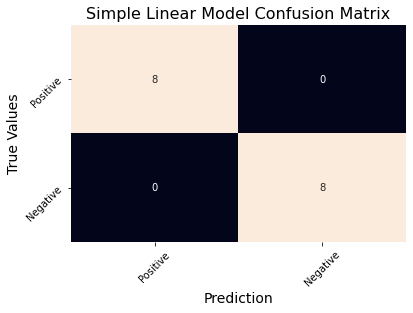

In [26]:
simple_cf = confusion_matrix(y_true, y_pred_simple)
sns.heatmap(simple_cf, annot=True, cbar=False)
plt.ylabel("True Values", size=14)
plt.yticks([0.5, 1.5], ["Positive", "Negative"], rotation=45)
plt.xlabel("Prediction", size=14)
plt.xticks([0.5, 1.5], ["Positive", "Negative"], rotation=45)
plt.title("Simple Linear Model Confusion Matrix", size=16)
plt.show()

### 2. Simple Linear Model with Large Decay

In [27]:
simple_linear_hard_decay = sl1_model.linear_prototype(img_reduce_h, img_reduce_w)
simple_linear_hard_decay.load_state_dict(torch.load("../models/pneumonia_simple_decay_02.pt"))
simple_linear_hard_decay.eval()

linear_prototype(
  (linear1): Linear(in_features=14400, out_features=320, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=320, out_features=1, bias=True)
  (termn_act): Sigmoid()
)

In [28]:
y_pred_sh = simple_linear_hard_decay(input_tensor)
y_pred_sh.flatten().detach().numpy()
y_pred_sh = np.array([1 if ans >= threshold else 0 for ans in y_pred_sh])

In [29]:
f1 = f1_score(y_true, y_pred_sh)
recall = recall_score(y_true, y_pred_sh)

print("Simple Model with Large Decay F1:", f1)
print("Simple Model with Large Decay Recall:", recall)

Simple Model with Large Decay F1: 1.0
Simple Model with Large Decay Recall: 1.0


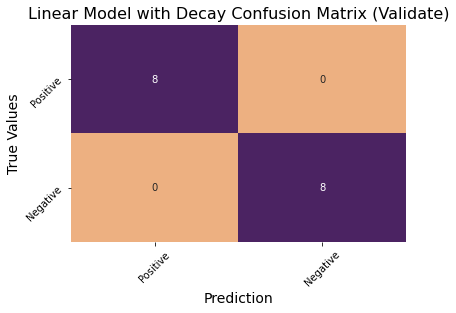

In [36]:
simple_large_cf = confusion_matrix(y_true, y_pred_sh)
sns.heatmap(simple_large_cf, annot=True, cbar=False, cmap="flare")
plt.ylabel("True Values", size=14)
plt.yticks([0.5, 1.5], ["Positive", "Negative"], rotation=45)
plt.xlabel("Prediction", size=14)
plt.xticks([0.5, 1.5], ["Positive", "Negative"], rotation=45)
plt.title("Linear Model with Decay Confusion Matrix (Validate)", size=16)
plt.show()

### 3. Linear Model with ReLU Activation

In [31]:
simple_linear_relu = sl2_model.linear_prototype(img_reduce_h, img_reduce_w)
simple_linear_relu.load_state_dict(torch.load("../models/pneumonia_simple_decay_03.pt"))
simple_linear_relu.eval()

linear_prototype(
  (linear1): Linear(in_features=14400, out_features=320, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=320, out_features=1, bias=True)
  (term_act): Sigmoid()
  (relu2): ReLU()
)

In [32]:
y_pred_rl = simple_linear_relu(input_tensor)
y_pred_rl.flatten().detach().numpy()
y_pred_rl = np.array([1 if ans >= threshold else 0 for ans in y_pred_rl])

In [33]:
f1 = f1_score(y_true, y_pred_rl)
recall = recall_score(y_true, y_pred_rl)

print("Linear Model with ReLU F1:", f1)
print("Linear Model with ReLU Recall:", recall)

Linear Model with ReLU F1: 0.9333333333333333
Linear Model with ReLU Recall: 0.875


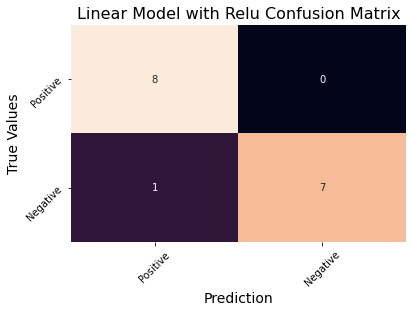

In [34]:
relu_cf = confusion_matrix(y_true, y_pred_rl)
sns.heatmap(relu_cf, annot=True, cbar=False)
plt.ylabel("True Values", size=14)
plt.yticks([0.5, 1.5], ["Positive", "Negative"], rotation=45)
plt.xlabel("Prediction", size=14)
plt.xticks([0.5, 1.5], ["Positive", "Negative"], rotation=45)
plt.title("Linear Model with Relu Confusion Matrix", size=16)
plt.show()